## Project description 
The main idea is  to predict the churn of the US telecom customer and prevent the abandon of the customer using data exploring, data preprocessing, model selection and fine-tuned model. 

The data set consists  of 3,333 records and 21 features which include 15 continuous and 6 categorical features.Since the data quality in this small data set is good, the main tasks focus on  data exploring, feature engineering and model selection and tuning. 

Among above steps, the feature engineering and creating an ensemble of models are important factors in this project to improve the predictive performance.The final fine-tuned model improves the f1 score by 36.4% compared to the baseline model.

Through the final model, we can find that Vmail_plan, Total_Charges, CustServ_Calls are as the most important indicators of churn. 

Next step: The current version of the analysis does not include 'state' information in the model. However, during the data exploration process, we found that 12 states, such as NJ, CA, and TX, have a churn rate of over 20%, which is significant higher than the average churn rate of 14%. In future versions of the analysis, we plan to incorporate this feature into the model

## Import packages and data

In [1]:

from pathlib import Path
import matplotlib.pyplot as plt
%matplotlib inline 
import seaborn as sns
import numpy as np
import pandas as pd
from numpy.random import randint
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.tree import DecisionTreeClassifier, ExtraTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import accuracy_score,precision_score,recall_score,precision_recall_curve,roc_curve,f1_score
from sklearn.pipeline import Pipeline
from xgboost import XGBClassifier

In [2]:
data_path =Path()/'datasets'/'TelcoChurn'
data_file ='Churn.csv'

In [3]:
telco = pd.read_csv(data_path/data_file)
telco_orig= telco.copy()
telco['Churn'] = telco['Churn'].replace({'yes':1,"no":0})
X = telco.drop('Churn', axis=1)
y= telco['Churn']

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=42)

## Exploring the data

### Overview

In [4]:
# create telco_train to do data exploring and data preprocessing test
telco_train=pd.concat([X_train,y_train], axis=1)

In [5]:

telco_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2666 entries, 817 to 3174
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Account_Length  2666 non-null   int64  
 1   Vmail_Message   2666 non-null   int64  
 2   Day_Mins        2666 non-null   float64
 3   Eve_Mins        2666 non-null   float64
 4   Night_Mins      2666 non-null   float64
 5   Intl_Mins       2666 non-null   float64
 6   CustServ_Calls  2666 non-null   int64  
 7   Intl_Plan       2666 non-null   object 
 8   Vmail_Plan      2666 non-null   object 
 9   Day_Calls       2666 non-null   int64  
 10  Day_Charge      2666 non-null   float64
 11  Eve_Calls       2666 non-null   int64  
 12  Eve_Charge      2666 non-null   float64
 13  Night_Calls     2666 non-null   int64  
 14  Night_Charge    2666 non-null   float64
 15  Intl_Calls      2666 non-null   int64  
 16  Intl_Charge     2666 non-null   float64
 17  State           2666 non-null  

In [6]:
telco_train.Churn.value_counts()

0    2284
1     382
Name: Churn, dtype: int64

nonChurner:2284, Churner:382


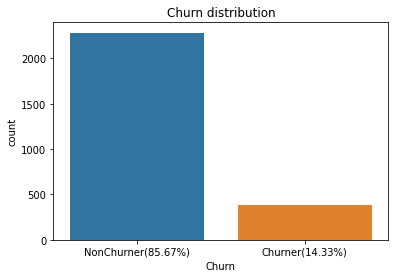

In [7]:
nonChurner, churner = telco_train.Churn.value_counts()[0], telco_train.Churn.value_counts()[1]
nonChurner_rate, churner_rate = round(100*nonChurner/len(telco_train),4), round(100*churner/len(telco_train),4)
print(f'nonChurner:{nonChurner}, Churner:{churner}')
sns.countplot(x=telco_train.Churn)
plt.xticks((0,1),['NonChurner({0:.2f}%)'.format(nonChurner_rate),'Churner({0:.2f}%)'.format(churner_rate) ])
plt.title('Churn distribution')
plt.show()

In [8]:
telco_train.describe()

,Account_Length,Vmail_Message,Day_Mins,Eve_Mins,Night_Mins,Intl_Mins,CustServ_Calls,Day_Calls,Day_Charge,Eve_Calls,Eve_Charge,Night_Calls,Night_Charge,Intl_Calls,Intl_Charge,Area_Code,Churn
count,2666.000000,2666.000000,2666.000000,2666.000000,2666.00000,2666.000000,2666.000000,2666.000000,2666.000000,2666.000000,2666.000000,2666.000000,2666.000000,2666.000000,2666.000000,2666.000000,2666.000000
mean,100.691673,7.981245,179.600713,200.698500,200.52982,10.237547,1.573143,100.542761,30.532629,99.963241,17.059599,99.911853,9.023905,4.450113,2.764647,436.806827,0.143286
std,39.522338,13.647218,54.351004,50.693277,50.71026,2.796937,1.338454,19.886485,9.239653,20.082759,4.308914,19.545034,2.281993,2.441808,0.755163,42.173756,0.350430
min,1.000000,0.000000,2.600000,0.000000,23.20000,0.000000,0.000000,30.000000,0.440000,0.000000,0.000000,33.000000,1.040000,0.000000,0.000000,408.000000,0.000000
25%,73.000000,0.000000,143.200000,165.825000,166.80000,8.500000,1.000000,88.000000,24.340000,87.000000,14.092500,86.000000,7.510000,3.000000,2.300000,408.000000,0.000000
50%,100.000000,0.000000,179.200000,200.850000,200.85000,10.300000,1.000000,101.000000,30.460000,100.000000,17.075000,100.000000,9.040000,4.000000,2.780000,415.000000,0.000000
75%,127.000000,19.000000,216.275000,234.650000,235.40000,12.000000,2.000000,114.000000,36.765000,113.000000,19.945000,113.000000,10.590000,6.000000,3.240000,415.000000,0.000000
max,243.000000,51.000000,350.800000,363.700000,395.00000,20.000000,9.000000,165.000000,59.640000,170.000000,30.910000,175.000000,17.770000,19.000000,5.400000,510.000000,1.000000


### Univariate analysis

In [9]:
num_ones = telco_train.select_dtypes(include= np.number).drop('Churn',axis=1)
cat_ones = telco_train.select_dtypes(include='object')

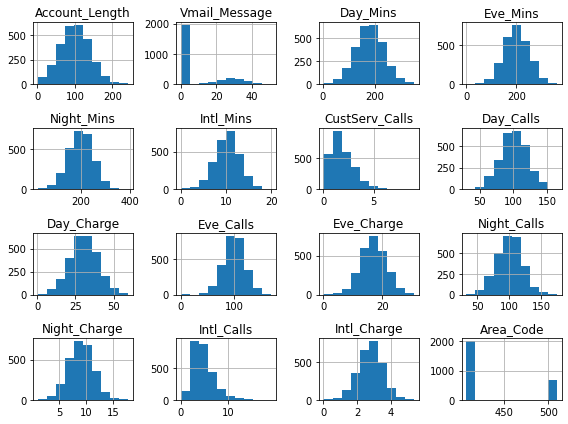

In [10]:
# numerical
num_ones.hist(figsize=(8,6))
plt.tight_layout()
plt.show()
# CustServ and Intl_Calls are right_skewed ones and they may need more investicate

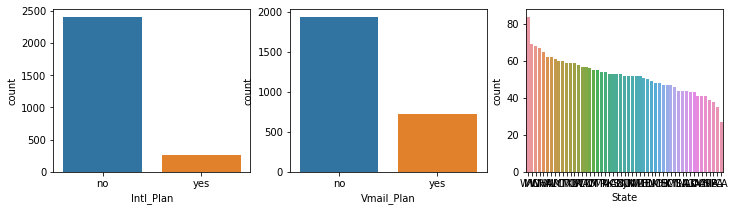

In [11]:
# categorical ones
def plot_cat_features_counts(df, cols):
    '''Plot the multiple categorical featues at once'''
    _, axes = plt.subplots(1, len(cols),figsize=(4*len(cols),3))
    for num,col in enumerate(cols):
        sns.countplot(ax=axes[num], x=col, data=df,
                     order = df[col].value_counts().index)
cat_cols =   cat_ones.columns.drop('Phone')
plot_cat_features_counts(df=telco_train, cols=cat_cols)

### Binvariate analysis

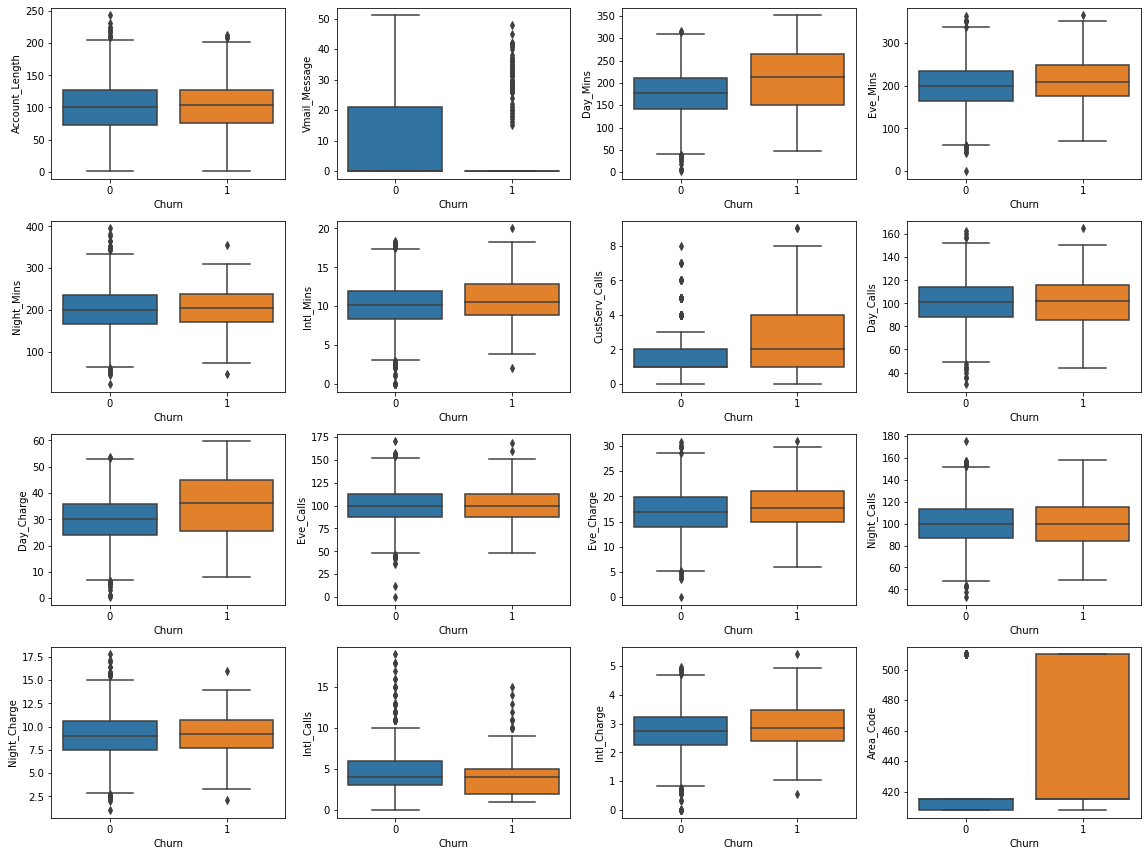

In [12]:
# explore the relationship between numerical ones and survived by boxplot plot(also could be viloin, count, swarm and bar plots)
target='Churn'
def plot_bivariate_cat_num_columns_box(target, cols, data, imgs_per_row=4):
    '''
    Explore bivariate relation between categorical and numerical with box plot
    '''
    m =(len(cols)-1)//imgs_per_row+1
    
    _, axes = plt.subplots(m,imgs_per_row,figsize= (4*imgs_per_row,3*m))
    for num, col in enumerate(cols):
        if m==1:
            sns.boxplot(ax=axes[num], x=target, y=col, data=data)
        else:
            n1=num//imgs_per_row
            if num<imgs_per_row:
                m1=num
            else:       m1=num-n1*imgs_per_row
            sns.boxplot(ax=axes[n1,m1], x=target, y=col, data=data)
    plt.tight_layout()

plot_bivariate_cat_num_columns_box(target=target, cols=num_ones.columns, data=telco_train)
# churners make significantly more service call,day_mins, day_charge and less Vmail_Message than non-churners
# churners make little more intl_mins in less intl_call than non-churners, is this an interest indicator?


In [13]:
telco_train[['Churn','CustServ_Calls', 'Vmail_Message']].groupby('Churn').agg(['mean','std']).round(3)
# churners make more service call than non-churners

CustServ_Calls        Vmail_Message        
                mean    std          mean     std
Churn                                            
0              1.457  1.179         8.478  13.889
1              2.270  1.907         5.013  11.682

In [14]:
# explore the relationship between categorical one and numerical target by count plot


def plot_bivariate_cat_num_columns(target, cols, data,imgs_per_row=4):
    '''
    Explore bivariate relation between categorical ones with target using barh plot
    '''
    m =(len(cols)-1)//imgs_per_row+1
    _, axes = plt.subplots(m,imgs_per_row,figsize=(4*imgs_per_row,3))
    for num, col in enumerate(cols): 
        if m==1:
            sns.barplot(ax=axes[num], x=target, y=col,data=data)
        else:
            n1 = num//imgs_per_row
            m1 = num if num<imgs_per_row else num-n1*imgs_per_row
  
            sns.barplot(ax=axes[n1,m1], x=target, y=col,data=data)
    plt.tight_layout()

In [15]:

telco_train['Churn'].sum()

382

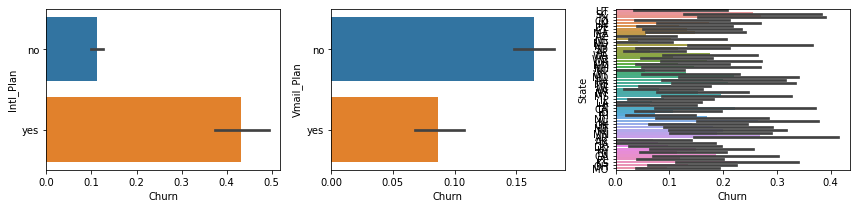

In [16]:
cat_cols =['Intl_Plan', 'Vmail_Plan','State']
plot_bivariate_cat_num_columns(target='Churn', cols= cat_cols, data= telco_train,imgs_per_row=3)
# the customer have intl plan and do not have Vmail seems more like to churn, are they the involunterr/volunteer churn

In [17]:
# Count the number of churners and non-churners by State 

state_churn =telco_train.groupby('State')['Churn'].value_counts().unstack()
state_churn['churn_rate'] = round(state_churn[1]/state_churn.sum(axis=1),4)
state_churn.sort_values('churn_rate', ascending=False)

# From state view, NJ, CA, TX etc. 12 states have more than 20% churn


Churn,0,1,churn_rate
State,,,
TX,43,16,0.2712
AR,30,11,0.2683
NJ,39,14,0.2642
SC,35,12,0.2553
NV,39,13,0.2500
KS,41,12,0.2264
CA,21,6,0.2222
MD,46,13,0.2203
ME,38,10,0.2083


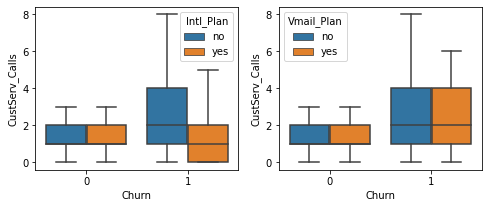

In [18]:
# whether the customer with intl plan and Vmail plan have difference in customer service call for churner and nonChurner
cols=['Intl_Plan','Vmail_Plan']
_,axes = plt.subplots(1,2,figsize=(8,3))
for num,col in enumerate(cols):
    sns.boxplot(ax=axes[num],x = 'Churn',
            y = 'CustServ_Calls',
            data = telco_train,
            sym = "",
            hue = col)
plt.show()

### Conclusion
* It looks like customers who do churn end up leaving more customer service calls, unless these customers also have an international plan, in which case they leave fewer customer service calls.
* From state view, NJ, CA, TX etc. 12 states have more than 20% churn
* Besides service call, churners also make more day_mins, day_charge and less Vmail_Message than non-churners
* Churners make little more intl_mins in less intl_call than non-churners, is this an interest indicator?
* Last, CustServ and Intl_Calls are right_skewed ones and they need data transformation and more exploration

## Preprocessing for modeling
* Data preprocessing
    * feature scaling: standardization
    * encoding categorical data
* Feature selection and engineering
    * drop the unnecessary data, usually like phone, user_id, account_id
    * Highly correlated pairs-- need to drop one or some or creating new features through combination

### Encoding Categorical data
* For pipeline, its better to use LabelEncoder for binary features and onehot encoder for multiple features. 
* Also, pandas is good for a straightforward task, using replace and get_dummies. For demonstration, here I use pandas

In [19]:
def encoding_binary_features(df, cols):
    '''This function changes yes/no to 1/0 for each column in cols'''
    for col in cols:
        df[col] = df[col].replace({'yes':1, 'no':0})
        
    return df

telco_train = encoding_binary_features(telco_train,['Vmail_Plan','Intl_Plan'])

In [20]:

telco_train[['Vmail_Plan','Intl_Plan']].head()

,Vmail_Plan,Intl_Plan
817,0,0
1373,0,0
679,0,1
56,0,0
1993,0,0


In [21]:
# Perform one hot encoding on 'State'
telco_state = pd.get_dummies(telco_train['State'])
telco_state.head()

,AK,AL,AR,AZ,CA,CO,CT,DC,DE,FL,...,SD,TN,TX,UT,VA,VT,WA,WI,WV,WY
817,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
1373,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
679,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
56,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1993,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### Feature Scaling

In [22]:
def feature_scaling(df, column_names):
    '''Create a new df to contain scaled feature and their names'''
    scaled = StandardScaler().fit_transform(df)
    scaled_df = pd.DataFrame(scaled, columns= column_names)
    return scaled_df

In [23]:
scaled_cols=["Intl_Calls", "Night_Mins"]
df_scaled = feature_scaling(df=telco_train[scaled_cols], column_names=scaled_cols)
df_scaled.describe()

,Intl_Calls,Night_Mins
count,2.666000e+03,2.666000e+03
mean,-1.066081e-17,1.579132e-16
std,1.000188e+00,1.000188e+00
min,-1.822808e+00,-3.497578e+00
25%,-5.939798e-01,-6.652726e-01
50%,-1.843703e-01,6.315095e-03
75%,6.348486e-01,6.877646e-01
max,5.959771e+00,3.835647e+00


In [24]:
num_ones.describe()

,Account_Length,Vmail_Message,Day_Mins,Eve_Mins,Night_Mins,Intl_Mins,CustServ_Calls,Day_Calls,Day_Charge,Eve_Calls,Eve_Charge,Night_Calls,Night_Charge,Intl_Calls,Intl_Charge,Area_Code
count,2666.000000,2666.000000,2666.000000,2666.000000,2666.00000,2666.000000,2666.000000,2666.000000,2666.000000,2666.000000,2666.000000,2666.000000,2666.000000,2666.000000,2666.000000,2666.000000
mean,100.691673,7.981245,179.600713,200.698500,200.52982,10.237547,1.573143,100.542761,30.532629,99.963241,17.059599,99.911853,9.023905,4.450113,2.764647,436.806827
std,39.522338,13.647218,54.351004,50.693277,50.71026,2.796937,1.338454,19.886485,9.239653,20.082759,4.308914,19.545034,2.281993,2.441808,0.755163,42.173756
min,1.000000,0.000000,2.600000,0.000000,23.20000,0.000000,0.000000,30.000000,0.440000,0.000000,0.000000,33.000000,1.040000,0.000000,0.000000,408.000000
25%,73.000000,0.000000,143.200000,165.825000,166.80000,8.500000,1.000000,88.000000,24.340000,87.000000,14.092500,86.000000,7.510000,3.000000,2.300000,408.000000
50%,100.000000,0.000000,179.200000,200.850000,200.85000,10.300000,1.000000,101.000000,30.460000,100.000000,17.075000,100.000000,9.040000,4.000000,2.780000,415.000000
75%,127.000000,19.000000,216.275000,234.650000,235.40000,12.000000,2.000000,114.000000,36.765000,113.000000,19.945000,113.000000,10.590000,6.000000,3.240000,415.000000
max,243.000000,51.000000,350.800000,363.700000,395.00000,20.000000,9.000000,165.000000,59.640000,170.000000,30.910000,175.000000,17.770000,19.000000,5.400000,510.000000


### Feature Selection

#### drop the unnecessary features

In [25]:
def drop_features(df, cols):
    df = df.drop(cols, axis=1)
    return df
telco= drop_features(telco_train,['Area_Code','Phone'])

In [26]:
telco.columns

Index(['Account_Length', 'Vmail_Message', 'Day_Mins', 'Eve_Mins', 'Night_Mins',
       'Intl_Mins', 'CustServ_Calls', 'Intl_Plan', 'Vmail_Plan', 'Day_Calls',
       'Day_Charge', 'Eve_Calls', 'Eve_Charge', 'Night_Calls', 'Night_Charge',
       'Intl_Calls', 'Intl_Charge', 'State', 'Churn'],
      dtype='object')

#### Find correlated features

In [27]:
def build_correlation_df(df, num_cols):
    '''return correlation dataframe of input df's numerical columns '''
    cor_df=df[num_cols].corr().abs().unstack().sort_values(kind='quicksort', ascending=False).reset_index()
    cor_df.rename(columns={'level_0':'feature1', 'level_1':'feature2', 0:'coef'}, inplace=True)
    # remove every other rows for they are symmetric values. i.e a vs b == b vs a
    cor_df.drop(cor_df.iloc[1::2].index, inplace=True)
    # create new df without correlation with feature itself
    cor_df_noself =cor_df[cor_df.coef!=1].reset_index(drop=True)
    return cor_df_noself

num_cols=telco.select_dtypes(include=np.number).columns
cor_df=build_correlation_df(df=telco_train, num_cols=num_cols)
cor_df

,feature1,feature2,coef
0,Day_Mins,Day_Charge,1.000000
1,Eve_Charge,Eve_Mins,1.000000
2,Night_Charge,Night_Mins,0.999999
3,Intl_Charge,Intl_Mins,0.999993
4,Vmail_Message,Vmail_Plan,0.957088
...,...,...,...
148,Eve_Charge,Day_Mins,0.000157
149,Day_Mins,Eve_Mins,0.000153
150,Vmail_Message,Night_Mins,0.000152
151,Day_Charge,Eve_Charge,0.000147


In [28]:
# we could see Day_Charge and Day_Mins,Eve_Mins and Eve_Charge, Night_Mins and Night_Charge, intl_mins and Intl_Charge
# Vmail_Plan and Vmail_Message are highly correlated and we could create new one which based on the pair to replace them 
cor_df.head(10)

,feature1,feature2,coef
0,Day_Mins,Day_Charge,1.000000
1,Eve_Charge,Eve_Mins,1.000000
2,Night_Charge,Night_Mins,0.999999
3,Intl_Charge,Intl_Mins,0.999993
4,Vmail_Message,Vmail_Plan,0.957088
5,Churn,Intl_Plan,0.269064
6,Churn,CustServ_Calls,0.212852
7,Churn,Day_Charge,0.191806
8,Day_Mins,Churn,0.191804
9,Vmail_Plan,Churn,0.098363


### Feature Engineering
Based on the previous findings to create new features and drop redundant features

In [85]:
def add_new_features(df):
    '''
    Creat new features like Total minutes, total charges, total calls, cost per call and minutes per call.
    Also drop the redundent features
    '''
    df['Total_Mins'] =df[['Day_Mins', 'Eve_Mins', 'Night_Mins','Intl_Mins']].sum(axis=1)
    df['Total_Charges'] =df[['Day_Charge', 'Eve_Charge', 'Night_Charge','Intl_Charge']].sum(axis=1)
    df['Total_Calls'] =df[['Day_Calls', 'Eve_Calls', 'Night_Calls','Intl_Calls']].sum(axis=1)
    df['Cost_Call'] = round(df['Total_Charges']/df['Total_Calls'],4)
    df['Mins_Call'] = round(df['Total_Mins']/df['Total_Calls'],4)
    df.drop(['Day_Charge', 'Eve_Charge', 'Night_Charge','Intl_Charge'],axis=1,inplace=True)

    
    return df
    

In [30]:
telco_train = add_new_features(telco_train)

In [31]:
telco_train.head()

,Account_Length,Vmail_Message,Day_Mins,Eve_Mins,Night_Mins,Intl_Mins,CustServ_Calls,Intl_Plan,Vmail_Plan,Day_Calls,...,Intl_Calls,State,Area_Code,Phone,Churn,Total_Mins,Total_Charges,Total_Calls,Cost_Call,Mins_Call
817,243,0,95.5,163.7,264.2,6.6,2,0,0,92,...,6,UT,510,355-9360,0,530.0,43.82,279,0.1571,1.8996
1373,108,0,112.0,193.7,208.9,4.1,4,0,0,105,...,4,SC,415,399-6233,1,518.7,46.01,312,0.1475,1.6625
679,75,0,222.4,327.0,208.0,8.7,1,1,0,78,...,9,TX,415,384-2372,1,766.1,77.32,302,0.2560,2.5368
56,141,0,126.9,180.0,140.8,8.0,1,0,0,98,...,2,CO,415,340-5121,0,455.7,45.37,290,0.1564,1.5714
1993,86,0,216.3,266.3,214.0,4.5,0,0,0,96,...,3,IN,510,357-7893,0,701.1,70.26,286,0.2457,2.4514


In [32]:
# create base line model based on base feature engineering
def data_preparing_pipeline(df,num_cols,encoding_state=True, scaling_data=True, add_new_feature=False):    
    '''This is to do all data preparing work. num_cols is the columns that need to be scaled'''
    df = encoding_binary_features(df,['Vmail_Plan','Intl_Plan'])
    if encoding_state:
        df_state = pd.get_dummies(df['State'])
        df =pd.concat([df,df_state], axis=1).drop('State', axis=1)
    else: df= df.drop('State', axis=1)
    df =drop_features(df,['Area_Code','Phone'])

    if add_new_feature:
        df=add_new_features(df)
   
    if scaling_data:
        df_scaled = feature_scaling(df=df[num_cols], column_names=num_cols)
        df1=df.drop(num_cols,axis=1)        
        df=pd.concat([df1,df_scaled], axis=1)       

       
    return df


## Model Selection

In [33]:
def model_tune(model,X_train, y_train, X_test):
    model.fit(X_train, y_train)
    y_predict = lr.predict(X_test)
    print('precision score is {:.4f}'.format(precision_score(y_test, y_predict)))
    print('recall score is {:.4f}'.format(recall_score(y_test, y_predict)))
    print('accuracy score is {:.4f}'.format(accuracy_score(y_test, y_predict)))
    
    y_pred_prob = model.predict_proba(X_test)[:,1]
    fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
    plt.plot(fpr,tpr)
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.plot([0, 1], [0, 1], "k--")
    plt.show()


### Use logistic Regression Model as baseline(not work well)

In [34]:
def plot_coef(model, feature_name, top_features=10):
    coef = model.coef_.ravel()
    negative_top_coefs = np.argsort(coef)[:top_features]
    positive_top_coefs = np.argsort(coef)[-top_features:]
    top_coefs=np.hstack([negative_top_coefs, positive_top_coefs])
    
    #Create plot
    plt.figure(figsize=(15,5))
    colors =['red' if c < 0 else 'blue' for c in coef[top_coefs]]
    plt.bar(x=np.arange(2* top_features), height=coef[top_coefs], color=colors)
#     feature_name = np.array(feature_name)
    plt.xticks(np.arange(2*top_features), feature_name[top_coefs], rotation=60,ha='right')

    plt.show()


#### Train dataset that does not add new features

In [35]:
lr= LogisticRegression(random_state=42)
X_train_copy = X_train.copy().reset_index(drop=True)
X_test_copy =X_test.copy().reset_index(drop=True)
num_cols = ['Account_Length', 'Vmail_Message', 'Day_Mins', 'Eve_Mins', 'Night_Mins',
       'Intl_Mins', 'CustServ_Calls',  'Day_Calls',
       'Day_Charge', 'Eve_Calls', 'Eve_Charge', 'Night_Calls', 'Night_Charge',
       'Intl_Calls', 'Intl_Charge']
X_train_processed = data_preparing_pipeline(X_train_copy,encoding_state=False,num_cols=num_cols,add_new_feature=False)
X_test_processed = data_preparing_pipeline(X_test_copy,encoding_state=False,num_cols=num_cols,add_new_feature=False)

precision score is 0.5862
recall score is 0.1683
accuracy score is 0.8561


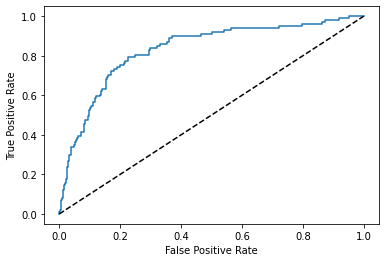

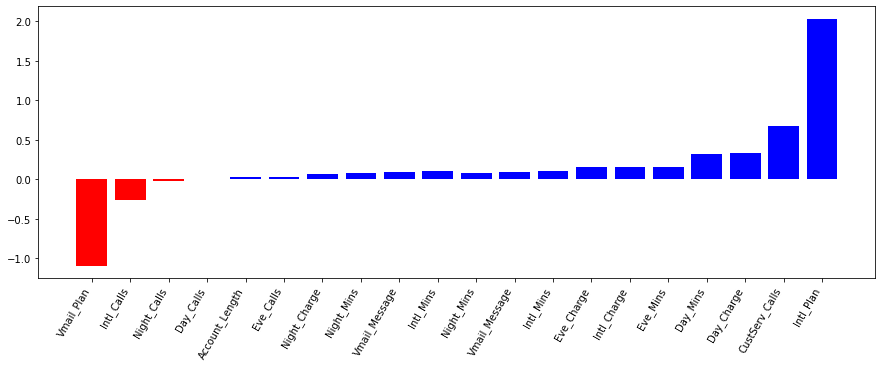

In [36]:
model_tune(lr,  X_train_processed, y_train, X_test_processed)
plot_coef(lr, feature_name=X_test_processed.columns)

#### Train dataset that does  add new features

In [37]:
lr= LogisticRegression(random_state=42)
num_cols = ['Account_Length', 'Vmail_Message', 'Day_Mins', 'Eve_Mins', 'Night_Mins',
       'Intl_Mins', 'CustServ_Calls',  'Day_Calls', 'Eve_Calls', 'Night_Calls','Intl_Calls'
#             , 'Intl_Charge','Day_Charge', 'Eve_Charge', 'Night_Charge'
            ,'Total_Mins','Total_Charges', 'Total_Calls', 'Cost_Call','Mins_Call']
X_train_copy = X_train.copy().reset_index(drop=True)
X_test_copy =X_test.copy().reset_index(drop=True)
X_train_processed_f = data_preparing_pipeline(X_train_copy,encoding_state=False,num_cols=num_cols,add_new_feature=True)
X_test_processed_f = data_preparing_pipeline(X_test_copy,encoding_state=False,num_cols=num_cols,add_new_feature=True)


precision score is 0.5862
recall score is 0.1683
accuracy score is 0.8561


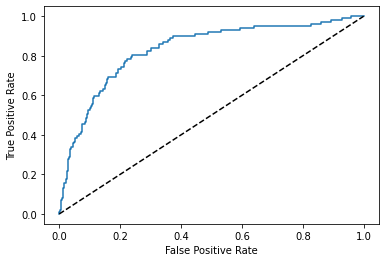

In [38]:
model_tune(lr,  X_train_processed_f, y_train, X_test_processed_f)

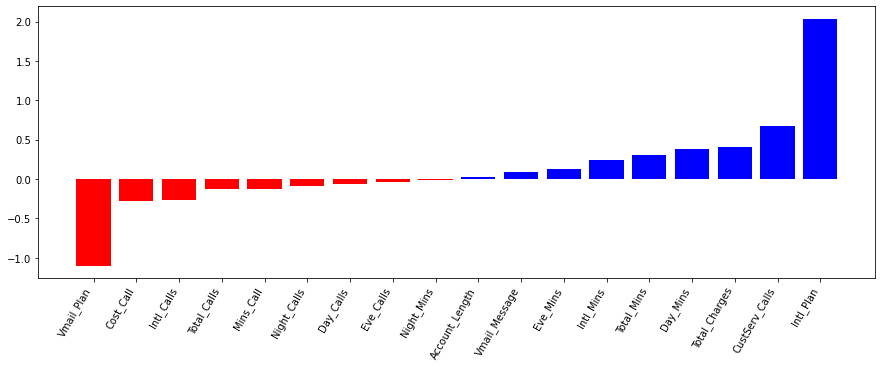

In [39]:
plot_coef(lr, feature_name=X_test_processed_f.columns, top_features=9)

* LR is not good for this problem for there exists non linear relationships, but it gives the features that have high correlation with the churn, like Intl_Plan, CustServ_Calls, Total_Charges and Vmail_Plan 

### Check different models
* Try as many as possible basic models to find some promising ones
* Try both model sets in original features and transformed+added features

#### Build multiple models 

In [ ]:
seed=42

lr= LogisticRegression(random_state=42)
# for svc, different kernel‘linear’, ‘poly’, ‘rbf’, ‘sigmoid’, ‘precomputed’ are worth to try
svc_rbf = SVC(random_state=42)
svc_linear = SVC(kernel='linear',random_state=42)
svc_poly = SVC(kernel='poly',random_state=42)
svc_sigmoid = SVC(kernel='sigmoid',random_state=42)
svc_precomputed = SVC(kernel='precomputed',random_state=42)
dt = DecisionTreeClassifier(random_state=42)
ext_tree = ExtraTreeClassifier(random_state=42)
rdm_tree =RandomForestClassifier(random_state=42)
sgd_clf = SGDClassifier(random_state=42)
adaboost =AdaBoostClassifier(random_state=42)
xgboost = XGBClassifier(random_state=42)
gb_clf= GradientBoostingClassifier(random_state=42)
model_dict={'lr':lr, 'svc_rbf':svc_rbf, 'svc_poly':svc_poly,
            'svc_sigmoid':svc_sigmoid, 'dt':dt,
            'ext_tree':ext_tree,'rdm_tree':rdm_tree,'sgd':sgd_clf, 'adaboost':adaboost,
           'xgboost':xgboost, 'gb_clf':gb_clf}

#### with Original columns(after  necessary transfomation) 

In [40]:
cv_scores={}

for name, model in model_dict.items():
    cv_score= cross_val_score(model,X_train_processed,y_train, cv=10, scoring='recall')
    cv_scores[name]=cv_score
    print("%s %0.4f recall with a standard deviation of %0.3f" % (name, cv_score.mean(), cv_score.std()))
    
# if only using transformed original features,
# xgboost, gb_clf,rdm_tree,dt,ext_tree and svc_poly are top6 models from recall score

lr 0.1910 recall with a standard deviation of 0.066
svc_rbf 0.3843 recall with a standard deviation of 0.074
svc_poly 0.4263 recall with a standard deviation of 0.086
svc_sigmoid 0.1099 recall with a standard deviation of 0.042
dt 0.7252 recall with a standard deviation of 0.061
ext_tree 0.5183 recall with a standard deviation of 0.066
rdm_tree 0.7433 recall with a standard deviation of 0.050
sgd 0.2283 recall with a standard deviation of 0.107
adaboost 0.3271 recall with a standard deviation of 0.081
xgboost 0.7538 recall with a standard deviation of 0.070
gb_clf 0.7511 recall with a standard deviation of 0.056


In [41]:
for name, model in model_dict.items():
    cv_score= cross_val_score(model,X_train_processed,y_train, cv=10, scoring='precision')
    cv_scores[name]=cv_score
    print("%s %0.4f precision with a standard deviation of %0.3f" % (name, cv_score.mean(), cv_score.std()))
    
# rdm_tree,xgboost, gb_clf, svc_poly, svc_rbf and dt  are top6 models based on precision score

lr 0.5386 precision with a standard deviation of 0.118
svc_rbf 0.8956 precision with a standard deviation of 0.070
svc_poly 0.8970 precision with a standard deviation of 0.060
svc_sigmoid 0.2105 precision with a standard deviation of 0.068
dt 0.6759 precision with a standard deviation of 0.081
ext_tree 0.4947 precision with a standard deviation of 0.037
rdm_tree 0.9520 precision with a standard deviation of 0.035
sgd 0.5236 precision with a standard deviation of 0.145
adaboost 0.6003 precision with a standard deviation of 0.100
xgboost 0.9198 precision with a standard deviation of 0.043
gb_clf 0.9162 precision with a standard deviation of 0.055


In [81]:
for name, model in model_dict.items():
    cv_score= cross_val_score(model,X_train_processed,y_train, cv=10, scoring='accuracy')
    cv_scores[name]=cv_score
    print("%s %0.4f accuracy with a standard deviation of %0.3f" % (name, cv_score.mean(), cv_score.std()))
#  rdm_tree,xgboost, gb_clf, svc_poly, svc_rbf and dt  are top6 models based on accuracy score

lr 0.8612 accuracy with a standard deviation of 0.009
svc_rbf 0.9055 accuracy with a standard deviation of 0.012
svc_poly 0.9103 accuracy with a standard deviation of 0.011
svc_sigmoid 0.8155 accuracy with a standard deviation of 0.008
dt 0.9096 accuracy with a standard deviation of 0.021
ext_tree 0.8552 accuracy with a standard deviation of 0.011
rdm_tree 0.9576 accuracy with a standard deviation of 0.007
sgd 0.8593 accuracy with a standard deviation of 0.020
adaboost 0.8725 accuracy with a standard deviation of 0.014
xgboost 0.9550 accuracy with a standard deviation of 0.010
gb_clf 0.9539 accuracy with a standard deviation of 0.008


#### After add new features

In [45]:
for name, model in model_dict.items():
    cv_score= cross_val_score(model,X_train_processed_f,y_train, cv=10, scoring='recall')
    cv_scores[name]=cv_score
    print("%s %0.4f recall with a standard deviation of %0.3f" % (name, cv_score.mean(), cv_score.std()))
    
# After add new features, the overall recalls are  improved
#  gb_clf,xgboost,rdm_tree,dt,  ext_tree and ada_boost  are top6 models based on recall score

lr 0.1964 recall with a standard deviation of 0.064
svc_rbf 0.4867 recall with a standard deviation of 0.056
svc_poly 0.4789 recall with a standard deviation of 0.078
svc_sigmoid 0.0995 recall with a standard deviation of 0.047
dt 0.8455 recall with a standard deviation of 0.066
ext_tree 0.5571 recall with a standard deviation of 0.090
rdm_tree 0.8297 recall with a standard deviation of 0.072
sgd 0.2462 recall with a standard deviation of 0.141
adaboost 0.5366 recall with a standard deviation of 0.077
xgboost 0.8532 recall with a standard deviation of 0.066
gb_clf 0.8585 recall with a standard deviation of 0.070


In [82]:
for name, model in model_dict.items():
    cv_score= cross_val_score(model,X_train_processed_f,y_train, cv=10, scoring='accuracy')
    cv_scores[name]=cv_score
    print("%s %0.4f accuracy with a standard deviation of %0.3f" % (name, cv_score.mean(), cv_score.std()))
    
# After add new features, the overall accuraries are improved
#  gb_clf,xgboost, rdm_tree,dt,svc_rbf and svc_poly are top6 models based on accuracy score

lr 0.8616 accuracy with a standard deviation of 0.008
svc_rbf 0.9201 accuracy with a standard deviation of 0.010
svc_poly 0.9145 accuracy with a standard deviation of 0.011
svc_sigmoid 0.7885 accuracy with a standard deviation of 0.023
dt 0.9452 accuracy with a standard deviation of 0.013
ext_tree 0.8732 accuracy with a standard deviation of 0.019
rdm_tree 0.9756 accuracy with a standard deviation of 0.010
sgd 0.8646 accuracy with a standard deviation of 0.017
adaboost 0.9088 accuracy with a standard deviation of 0.015
xgboost 0.9786 accuracy with a standard deviation of 0.009
gb_clf 0.9790 accuracy with a standard deviation of 0.011


In [44]:
for name, model in model_dict.items():
    cv_score= cross_val_score(model,X_train_processed_f,y_train, cv=10, scoring='precision')
    cv_scores[name]=cv_score
    print("%s %0.4f precision with a standard deviation of %0.3f" % (name, cv_score.mean(), cv_score.std()))
    
# The overall precisions are also improved
# The random tree is overfitting. the other top 5 models are xgboost, gb_clf, svc_rbf, svc_poly and dt

lr 0.5436 precision with a standard deviation of 0.096
svc_rbf 0.9182 precision with a standard deviation of 0.058
svc_poly 0.8674 precision with a standard deviation of 0.062
svc_sigmoid 0.1507 precision with a standard deviation of 0.074
dt 0.7911 precision with a standard deviation of 0.052
ext_tree 0.5625 precision with a standard deviation of 0.075
rdm_tree 1.0000 precision with a standard deviation of 0.000
sgd 0.6452 precision with a standard deviation of 0.175
adaboost 0.7579 precision with a standard deviation of 0.079
xgboost 0.9971 precision with a standard deviation of 0.009
gb_clf 0.9937 precision with a standard deviation of 0.013


#### baseline

In [46]:
# Using svc_rbf model as the base model and get scores before adding new features
svc_rbf.fit(X_train_processed, y_train)
y_test_predict_base = svc_rbf.predict(X_test_processed)
print("%0.4f recall"%( recall_score(y_test, y_test_predict_base)))
print("%0.4f precision"%(precision_score(y_test, y_test_predict_base)))
print("%0.4f accuracy"%(accuracy_score(y_test,y_test_predict_base)))
print("%0.4f f1 score"%(f1_score(y_test,y_test_predict_base)))

0.4950 recall
0.9804 precision
0.9220 accuracy
0.6579 f1 score


In [80]:
# Using svc_rbf as the base model and get scores after adding new features
svc_rbf.fit(X_train_processed_f, y_train)
y_test_predict_base = svc_rbf.predict(X_test_processed_f)
print("%0.4f recall"%( recall_score(y_test, y_test_predict_base)))
print("%0.4f precision"%(precision_score(y_test, y_test_predict_base)))
print("%0.4f accuracy"%(accuracy_score(y_test,y_test_predict_base)))
print("%0.4f f1 score"%(f1_score(y_test,y_test_predict_base)))

0.5149 recall
0.9630 precision
0.9235 accuracy
0.6710 f1 score


#### Conclusion
* Adding new features brings overall performance improvement
* GradientBoostingclf, xgboost, randomForest those three ensemble method are top 3 models. followed by decision tree, svc with poly kernel and rbf kernel. These indicates that there exists nonlinear relationship between features and target

### Fine tune the parameters

In [48]:
# Focus on random tree, GradientBoostingclf and xgboost to tune the parameters on processed features

classifiers =[
    RandomForestClassifier(random_state=42),
    XGBClassifier(random_state=42, objective='binary:logistic'),
    GradientBoostingClassifier(random_state=42)
]

classifier_names=[
    'rf',
    'xgboost',
    'gbc'
]



In [54]:
# since the dataset and features is not huge, I use gridsearch method here
def GridSearchCV_work(pipeline, train_x, train_y, test_x, test_y, param_grid, score= "recall"):
    response={}
    gridsearch=GridSearchCV(estimator=pipeline, param_grid=param_grid, scoring=score)
    search = gridsearch.fit(train_x, train_y)
    print('GridSearch Best parameters:', search.best_params_)
    print('GridSearch Best Score:',search.best_score_)
    predict_y = search.best_estimator_.predict(test_x)
    recalls=recall_score(test_y, predict_y)
    precisions=precision_score(test_y, predict_y)
    accuracys=accuracy_score(test_y, predict_y)
    f1=f1_score(test_y, predict_y)
    print("%0.4f recall"%( recalls))
    print("%0.4f precision"%(precisions))
    print("%0.4f accuracy"%(accuracys))
    print("%0.4f f1 score"%(f1))
    response['predict_y']=predict_y
    response['accuracy_score']=accuracys
    response['recall_score']=recalls
    response['precision_score']=precisions
    response['f1_score']=f1
    response['model'] =grid_search.best_estimator_
    return response



In [ ]:
# start with a few parameters
classifier_param_grid=[
    {'rf__max_depth':[3,6,9,10],

    },
    {'xgboost__n_estimators':[200,300,400],
     'xgboost__learning_rate':[0.001,0.01,0.1,0.3],


    },
    {'gbc__learning_rate':[0.001,0.01,0.1,0.3,0.6],

    }
]

In [50]:
results=[]
for model,model_name, model_param_grid in zip(classifiers, classifier_names, classifier_param_grid):
    pipeline =Pipeline([
        (model_name, model)
    ])
    result = GridSearchCV_work(pipeline=pipeline,train_x=X_train_processed_f, train_y=y_train,
                               test_x=X_test_processed_f, test_y=y_test,
                              param_grid= model_param_grid)
    results.append(result)
    
    

GridSearch Best parameters: {'rf__max_depth': 9}
GridSearch Best Score: 0.8349965823650034
0.8020 recall
0.9878 precision
0.9685 accuracy
0.8852 f1 score
GridSearch Best parameters: {'xgboost__learning_rate': 0.1, 'xgboost__n_estimators': 200}
GridSearch Best Score: 0.8533151059466849
0.8218 recall
0.9881 precision
0.9715 accuracy
0.8973 f1 score
GridSearch Best parameters: {'gbc__learning_rate': 0.6}
GridSearch Best Score: 0.8585440874914558
0.8218 recall
0.9651 precision
0.9685 accuracy
0.8877 f1 score


In [52]:
# Accourding to the 1st round fine-tuned result,more hyper parameters are tuned
classifier_param_grid2=[
    {'rf__max_depth':[9],
     'rf__n_estimators':[250,300,330],
     'rf__bootstrap': [True, False]
     ,'rf__max_features':['sqrt','log2']
    },
    {'xgboost__n_estimators':[250,300,350],
     'xgboost__learning_rate':[0.05,0.1,0.15],  
     'xgboost__max_depth':[5,7,9,10],
     'xgboost__reg_lambda':[0.6,0.7,0.8],
     'xgboost__colsample_bytree':[0.6,0.7,0.8,0.9],
     'xgboost__scale_pos_weight':[1]
    },
    {
     'gbc__learning_rate':[0.05, 0.1, 0.15],
     'gbc__n_estimators':[100,200,300],
     'gbc__max_depth':[6,8,9], 
     'gbc__max_features':[0.25,0.3,0.4], 
    }
]

In [53]:
results2=[]
for model,model_name, model_param_grid in zip(classifiers, classifier_names, classifier_param_grid2):
    pipeline =Pipeline([
        (model_name, model)
    ])
    result = GridSearchCV_work(pipeline=pipeline,train_x=X_train_processed_f, train_y=y_train,
                               test_x=X_test_processed_f, test_y=y_test,
                              param_grid= model_param_grid)
    results2.append(result)

GridSearch Best parameters: {'rf__bootstrap': False, 'rf__max_depth': 9, 'rf__max_features': 'sqrt', 'rf__n_estimators': 250}
GridSearch Best Score: 0.8428229665071768
0.8218 recall
0.9881 precision
0.9715 accuracy
0.8973 f1 score
GridSearch Best parameters: {'xgboost__colsample_bytree': 0.7, 'xgboost__learning_rate': 0.1, 'xgboost__max_depth': 5, 'xgboost__n_estimators': 350, 'xgboost__reg_lambda': 0.8, 'xgboost__scale_pos_weight': 1}
GridSearch Best Score: 0.8559125085440875
0.8218 recall
0.9881 precision
0.9715 accuracy
0.8973 f1 score
GridSearch Best parameters: {'gbc__learning_rate': 0.05, 'gbc__max_depth': 6, 'gbc__max_features': 0.4, 'gbc__n_estimators': 300}
GridSearch Best Score: 0.8559125085440875
0.8218 recall
0.9881 precision
0.9715 accuracy
0.8973 f1 score


In [ ]:
# It seems the results are tied now. Focus on XGBoost to get further fine-tuned for this model 


param_grid={'n_estimators':[300,350,400,450],
     'learning_rate':[0.1],  
     'max_depth':[4,5,6,7],
     'reg_lambda':[0.7,0.8,0.85],
     'colsample_bytree':[0.65,0.7,0.75],
     'scale_pos_weight':[1]
    }
xgb_clf =XGBClassifier(random_state=42, objective='binary:logistic')
grid_search= GridSearchCV(estimator=xgb_clf, param_grid=param_grid, scoring='recall', n_jobs=4, cv=5)
grid_search.fit(X_train_processed_f,y_train)

In [65]:
def print_metrics(search, X_test, y_test):
    print(grid_search.best_params_)
    print(grid_search.best_score_)
    y_predict_grid_rdt = grid_search.best_estimator_.predict(X_test)
    print("%0.4f recall"%( recall_score(y_test, y_predict_grid_rdt)))
    print("%0.4f precision"%(precision_score(y_test, y_predict_grid_rdt)))
    print("%0.4f accuracy"%(accuracy_score(y_test,y_predict_grid_rdt)))
    print("%0.4f f1 score"%(f1_score(y_test,y_predict_grid_rdt)))
    

In [66]:
print_metrics(grid_search, X_test=X_test_processed_f, y_test=y_test)
# the best score is improved while the other are keep the same

{'colsample_bytree': 0.7, 'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 350, 'reg_lambda': 0.85, 'scale_pos_weight': 1}
0.8585099111414902
0.8218 recall
0.9881 precision
0.9715 accuracy
0.8973 f1 score


In [76]:
param_grid = {
 'reg_alpha':[1e-5, 1e-2, 0.1, 1, 100]
}
xgb_clf =XGBClassifier(random_state=42, objective='binary:logistic', colsample_bytree= 0.7,
                       learning_rate=0.1, max_depth= 5, n_estimators= 350, reg_lambda= 0.85,
                       scale_pos_weight= 1)
grid_search= GridSearchCV(estimator=xgb_clf, param_grid=param_grid, scoring='recall', n_jobs=4, cv=5)
grid_search.fit(X_train_processed_f,y_train)
print_metrics(grid_search, X_test=X_test_processed_f, y_test=y_test)
# Now we can see a no significant boost in performance and we've done the work in parameter tuning for now

{'reg_alpha': 1e-05}
0.8585099111414902
0.8218 recall
0.9881 precision
0.9715 accuracy
0.8973 f1 score


### Find the features related to the churn

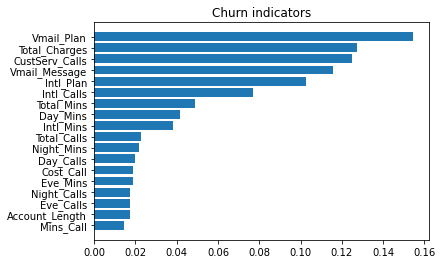

In [79]:
final_model = grid_search.best_estimator_
importances = final_model.feature_importances_

sorted_index= np.argsort(importances)
labels = X_train_processed_f.columns[sorted_index]
plt.barh(range(X_train_processed_f.shape[1]), importances[sorted_index],tick_label=labels)
plt.title('Churn realted features importances')
plt.show()



### Conclusion
As it comes to an end,  2 key thoughts are here:

* It is difficult to get a very big leap in performance by just using parameter tuning or slightly better models. The max f1 score for XGBoost, random forest and GBC are all 0.8973
* A significant jump can be obtained by other methods like feature engineering, creating an ensemble of models, stacking, etc.
* The final model compare to the baseline model without feature engineering, its f1 score improve 36.4%
* Through the final model, we can find that Vmail_plan, Total_Charges, CustServ_Calls are the most important indicators of churn.

In [83]:
(0.8973-0.6579)/0.6579

0.36388508891928856